# Loading graph

In [1]:
from ogb.nodeproppred import NodePropPredDataset

In [2]:
dataset = NodePropPredDataset(name="ogbn-arxiv")

/home/marcovinha/llm_graph_embedder/.venv/lib/python3.10/site-packages/ogb/nodeproppred/dataset.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load

In [3]:
graph, labels = dataset[0]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from umap.umap_ import UMAP
from matplotlib.colors import ListedColormap


def reduce_dimensions(vectors):
    reducer = UMAP()
    reducer.fit(vectors)
    vectors = reducer.transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]

    return x_vals, y_vals


def plot_embeddings(x_vals, y_vals, labels):
    random.seed(0)
    plt.figure(figsize=(12, 12))

    scatter = plt.scatter(
        x_vals,
        y_vals,
        c=labels,
        cmap=ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20)).tolist() * 2),
        s=10,  # Adjust size of points if needed
        alpha=0.8,  # Adjust transparency for better visibility
    )

    plt.colorbar(scatter, ticks=np.arange(0, 40, step=1), label="Classes")
    plt.title("2D Embedding Visualization with Class Colors")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [5]:
x, y = reduce_dimensions(graph["node_feat"])

/home/marcovinha/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/marcovinha/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


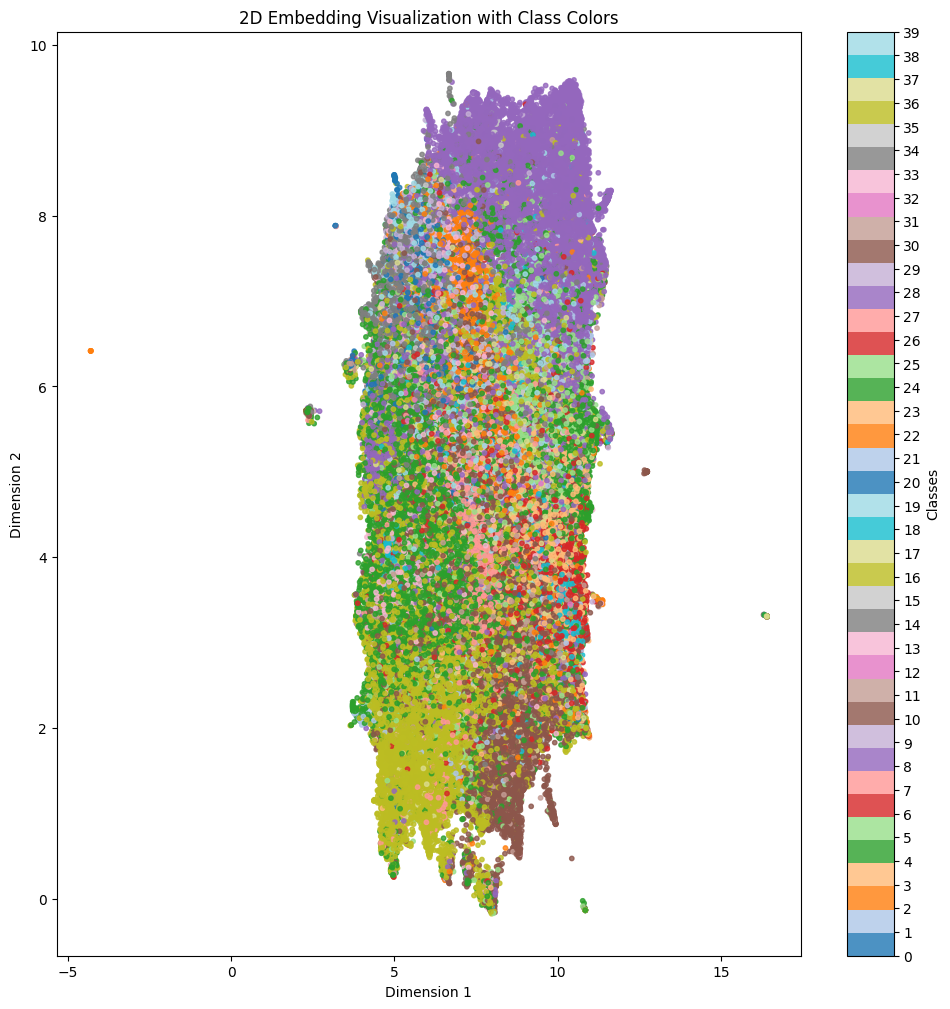

In [6]:
plot_embeddings(x, y, labels)

# Loading text features

OGB provides a file with all text features related to a papar (title and abstract): https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv

In [7]:
import pandas as pd

text_features = pd.read_csv(
    "../titleabs.tsv",
    sep="\t",
    header=None,
    skiprows=1,
    names=["paper_id", "title", "abstract"],
    index_col="paper_id",
)

text_features = text_features.dropna()
text_features.index = text_features.index.map(int)
text_features

,title,abstract
paper_id,,
549074,a novel methodology for thermal analysis a 3 d...,The semiconductor industry is reaching a fasci...
630234,spreadsheets on the move an evaluation of mobi...,The power of mobile devices has increased dram...
803423,multi view metric learning for multi view vide...,Traditional methods on video summarization are...
1102481,big data analytics in future internet of things,Current research on Internet of Things (IoT) m...
1532644,machine learner for automated reasoning 0 4 an...,Machine Learner for Automated Reasoning (MaLAR...
...,...,...
3012554562,federated visual classification with real worl...,Federated Learning enables visual models to be...
3012555423,kernel quantization for efficient network comp...,This paper presents a novel network compressio...
3012556759,generating electronic health records with mult...,Sharing electronic health records (EHRs) on a ...


In [8]:
node_idx_to_paper_id = pd.read_csv(
    "./dataset/ogbn_arxiv/mapping/nodeidx2paperid.csv",
    index_col=0,
    names=["node_idx", "paper_id"],
    header=None,
    skiprows=1,
)
node_idx_to_paper_id

,paper_id
node_idx,
0,9657784
1,39886162
2,116214155
3,121432379
4,231147053
...,...
169338,3011696425
169339,3011708313
169340,3011798063


In [9]:
node_text_features = pd.merge(
    node_idx_to_paper_id,
    text_features,
    left_on="paper_id",
    right_on=text_features.index,
)
node_text_features.index.names = ["node_idx"]

In [10]:
node_text_features["publishing_year"] = graph["node_year"]
node_text_features

,paper_id,title,abstract,publishing_year
node_idx,,,,
0,9657784,evasion attacks against machine learning at te...,"In security-sensitive applications, the succes...",2013
1,39886162,how hard is computing parity with noisy commun...,We show a tight lower bound of $\Omega(N \log\...,2015
2,116214155,on the absence of the rip in real world applic...,The purpose of this paper is twofold. The firs...,2014
3,121432379,a promise theory perspective on data networks,Networking is undergoing a transformation thro...,2014
4,231147053,analysis of asymptotically optimal sampling ba...,Over the last 20 years significant effort has ...,2014
...,...,...,...,...
169338,3011696425,sentinet detecting localized universal attacks...,SentiNet is a novel detection framework for lo...,2020
169339,3011708313,interpretable mtl from heterogeneous domains u...,Multi-task learning (MTL) aims at improving th...,2020
169340,3011798063,learning compositional rules via neural progra...,"Many aspects of human reasoning, including lan...",2020


In [11]:
node_text_features["label"] = labels
node_text_features

,paper_id,title,abstract,publishing_year,label
node_idx,,,,,
0,9657784,evasion attacks against machine learning at te...,"In security-sensitive applications, the succes...",2013,4
1,39886162,how hard is computing parity with noisy commun...,We show a tight lower bound of $\Omega(N \log\...,2015,5
2,116214155,on the absence of the rip in real world applic...,The purpose of this paper is twofold. The firs...,2014,28
3,121432379,a promise theory perspective on data networks,Networking is undergoing a transformation thro...,2014,8
4,231147053,analysis of asymptotically optimal sampling ba...,Over the last 20 years significant effort has ...,2014,27
...,...,...,...,...,...
169338,3011696425,sentinet detecting localized universal attacks...,SentiNet is a novel detection framework for lo...,2020,4
169339,3011708313,interpretable mtl from heterogeneous domains u...,Multi-task learning (MTL) aims at improving th...,2020,24
169340,3011798063,learning compositional rules via neural progra...,"Many aspects of human reasoning, including lan...",2020,10


In [12]:
# Select all rows in node_text_features where publishing_year is 2018
node_text_features[node_text_features["publishing_year"] == 2018]

,paper_id,title,abstract,publishing_year,label
node_idx,,,,,
349,2582667927,flexonc joint cooperative forwarding and netwo...,"In recent years, network coding has emerged as...",2018,8
357,2591735613,statistical anomaly detection via composite hy...,"Under Markovian assumptions, we leverage a cen...",2018,19
366,2604507718,sce a manifold regularized set covering method...,Cluster analysis plays a very important role i...,2018,16
382,2611510109,understanding people flow in transportation hubs,"In this paper, we aim to monitor the flow of p...",2018,16
393,2621813772,the temporal event graph,Temporal networks are increasingly being used ...,2018,26
...,...,...,...,...,...
169155,2965531707,augmented reality based feedback for technicia...,Interventional C-arm imaging is crucial to per...,2018,16
169176,2971687264,privado practical and secure dnn inference wit...,Cloud providers are extending support for trus...,2018,4
169185,2972582134,collective learning from diverse datasets for ...,Entity typing (ET) is the problem of assigning...,2018,30


# Loading graph instructions

In [14]:
import pandas as pd

train_instructions = pd.read_json("hf://datasets/Jiabin99/Arxiv-PubMed-mix-NC-LP/arxiv_pub_node_st_cot_link_mix.json")
train_instructions = train_instructions[train_instructions['id'].str.startswith("arxiv_train")]
train_instructions["node_idx"] = train_instructions["id"].apply(lambda x: x.split("_")[-1])
train_instructions.index = train_instructions["node_idx"]
train_instructions.index = train_instructions.index.map(int)

In [15]:
from datasets import load_dataset

eval_instructions = load_dataset("Jiabin99/GraphGPT-eval-instruction", split="test", data_files={"test": "arxiv_test_instruct_std.json"})
eval_instructions = pd.DataFrame(eval_instructions)
eval_instructions["node_idx"] = eval_instructions["id"].apply(lambda x: x.split("_")[-1])
eval_instructions.index = eval_instructions["node_idx"]
eval_instructions.index = eval_instructions.index.map(int)

# Merging text features and instructions

In [16]:
# Create a new dataframe that makes an inner join between `node_text_features` and `train_instructions` on the indexes of both dataframes
train_data = pd.merge(node_text_features, train_instructions, left_index=True, right_index=True)
train_data

,paper_id,title,abstract,publishing_year,label,id,graph,conversations,node_idx
node_idx,,,,,,,,,
0,9657784,evasion attacks against machine learning at te...,"In security-sensitive applications, the succes...",2013,4,arxiv_train_0,"{'node_idx': 0, 'edge_index': [[1, 2, 3, 4, 5,...","[{'from': 'human', 'value': 'Given a citation ...",0
1,39886162,how hard is computing parity with noisy commun...,We show a tight lower bound of $\Omega(N \log\...,2015,5,arxiv_train_1,"{'node_idx': 1, 'edge_index': [[1, 2, 3, 4, 0,...","[{'from': 'human', 'value': 'Given a citation ...",1
2,116214155,on the absence of the rip in real world applic...,The purpose of this paper is twofold. The firs...,2014,28,arxiv_train_2,"{'node_idx': 2, 'edge_index': [[1, 2, 3, 4, 5,...","[{'from': 'human', 'value': 'Given a citation ...",2
3,121432379,a promise theory perspective on data networks,Networking is undergoing a transformation thro...,2014,8,arxiv_train_3,"{'node_idx': 3, 'edge_index': [[1, 2, 0, 3, 4,...","[{'from': 'human', 'value': 'Given a citation ...",3
4,231147053,analysis of asymptotically optimal sampling ba...,Over the last 20 years significant effort has ...,2014,27,arxiv_train_4,"{'node_idx': 4, 'edge_index': [[1, 2, 3, 4, 5,...","[{'from': 'human', 'value': 'Given a citation ...",4
...,...,...,...,...,...,...,...,...,...
169113,2953374028,network error correction for unit delay memory...,A single source network is said to be memory-f...,2009,28,arxiv_train_169113,"{'node_idx': 169113, 'edge_index': [[1, 2, 3, ...","[{'from': 'human', 'value': 'Given a citation ...",169113
169115,2953380034,subgraph sparsification and nearly optimal ult...,We consider a variation of the spectral sparsi...,2009,39,arxiv_train_169115,"{'node_idx': 169115, 'edge_index': [[1, 2, 3, ...","[{'from': 'human', 'value': 'Given a citation ...",169115
169145,2963574152,hybrid spatio temporal artificial noise design...,This paper investigates artificial noise injec...,2017,28,arxiv_train_169145,"{'node_idx': 169145, 'edge_index': [[1, 2, 3, ...","[{'from': 'human', 'value': 'Given a citation ...",169145


In [17]:
min(train_data["publishing_year"]), max(train_data["publishing_year"])

(1986, 2017)

In [18]:
# Create a new dataframe that makes an inner join between `node_text_features` and `eval_insstructions` on the indexes of both dataframes
eval_data = pd.merge(node_text_features, eval_instructions, left_index=True, right_index=True)
eval_data

,paper_id,title,abstract,publishing_year,label,id,graph,conversations,node_idx
node_idx,,,,,,,,,
346,2580068393,factored contextual policy search with bayesia...,Scarce data is a major challenge to scaling ro...,2019,24,arxiv_test_346,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",346
398,2625226699,simultaneous merging multiple grid maps using ...,Mapping in the GPS-denied environment is an im...,2019,10,arxiv_test_398,"{'edge_index': [[1, 2, 3, 4, 0, 5, 6, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",398
451,2763049606,reconstruction of hidden representation for ro...,This article aims to develop a new and robust ...,2019,24,arxiv_test_451,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",451
480,2775899375,a look at the time delays in cvss vulnerabilit...,Abstract This empirical paper examines the t...,2019,4,arxiv_test_480,"{'edge_index': [[1, 2, 3, 4, 5, 6, 0, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",480
488,2782758897,common tangents of two disjoint polygons in li...,We provide a remarkably simple algorithm to co...,2019,20,arxiv_test_488,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",488
...,...,...,...,...,...,...,...,...,...
169338,3011696425,sentinet detecting localized universal attacks...,SentiNet is a novel detection framework for lo...,2020,4,arxiv_test_169338,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",169338
169339,3011708313,interpretable mtl from heterogeneous domains u...,Multi-task learning (MTL) aims at improving th...,2020,24,arxiv_test_169339,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",169339
169340,3011798063,learning compositional rules via neural progra...,"Many aspects of human reasoning, including lan...",2020,10,arxiv_test_169340,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",169340


In [19]:
min(eval_data["publishing_year"]), max(eval_data["publishing_year"])

(2019, 2020)